### Most ambiguous words in terms of in how many emojis they appear

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from scipy.stats import entropy
import gensim.models as gs

from settings import E2V_EMBEDDINGS, EMBEDDINGS_PATH, AMBIGUITY_PATH
from src.analysis.embedded import calculate_vocabulary_variation, embedded_CIs
from src.data.utils import parallelize_dataframe

pd.set_option('mode.chained_assignment', None)

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
sns.set_style("white", {'axes.grid' : False})

In [2]:
ambiguity = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')
ambiguity.head()

,WorkerID,FormId,Duration,emoji_index,emoji,word
0,A19AAMLW7OP5V4,65,330.0,0,#️⃣,ash
1,A1DD23J1WBGQUU,65,315.0,0,#️⃣,hashtag
2,A2C7A6E70NYNUI,65,317.0,0,#️⃣,hashtag
3,A2CK0OXMPOR9LE,65,521.0,0,#️⃣,pound
4,A272X64FOZFYLB,65,329.0,0,#️⃣,pound


In [3]:
words_by_num_emojis = ambiguity.groupby("word").emoji.nunique().reset_index().rename({"emoji":"num_emojis"}, axis=1)

### What is the most ambiguous word?

In [4]:
words_by_num_emojis.nlargest(n=20, columns='num_emojis')

,word,num_emojis
1865,happy,69
4064,symbol,58
2374,love,43
2431,man,43
3410,sad,43
3738,smile,41
3646,sign,39
2288,letter,38
139,arrow,36
455,boy,34


In [5]:
words_by_num_emojis.describe()

,num_emojis
count,4698.000000
mean,2.333333
std,3.424790
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,69.000000


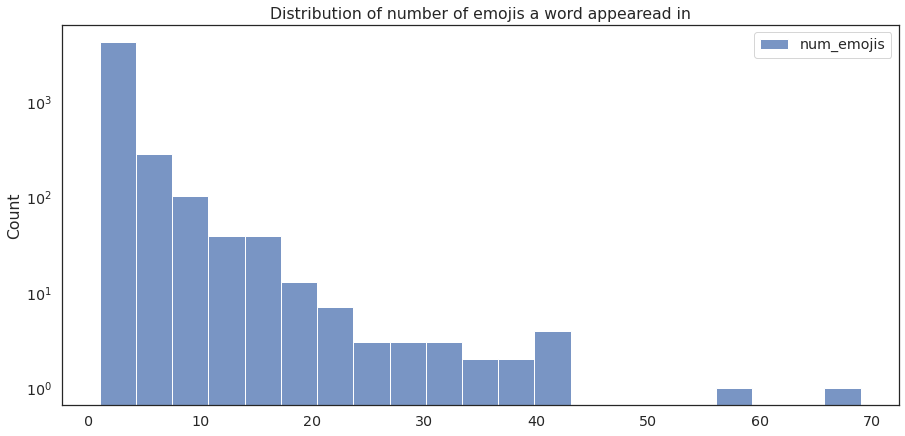

In [6]:
sns.histplot(words_by_num_emojis, log_scale=(False, True), bins='doane')\
        .set_title("Distribution of number of emojis a word appearead in");

In [7]:
words_by_num_emojis.sort_values(by="num_emojis")

,word,num_emojis
0,TRUE,1
2299,librarian,1
2300,library,1
2301,lick,1
2302,lie,1
...,...,...
2431,man,43
2374,love,43
3410,sad,43
4064,symbol,58


#### Median words in terms of ambiguity

In [8]:
words_by_num_emojis[words_by_num_emojis.num_emojis.sub(words_by_num_emojis.num_emojis.median()).abs().lt(0.001)]

,word,num_emojis
0,TRUE,1
2,aardvark,1
3,ab,1
4,abacus,1
5,abbreviations,1
...,...,...
4686,yum,1
4687,yummy,1
4688,zap,1
4692,zipped,1


#### Mean words in terms of ambiguity

In [9]:
words_by_num_emojis[words_by_num_emojis.num_emojis.sub(words_by_num_emojis.num_emojis.mean()).abs().lt(1)]

,word,num_emojis
8,abcs,2
10,above,2
14,accessible,2
17,ace,3
20,acorn,2
...,...,...
4690,zero,2
4691,zigzag,2
4693,zipper,2
4696,zombie,2


In [10]:
words_by_num_emojis.groupby("num_emojis").word.apply(set)

num_emojis
1     {stool, bunny face, sizzle, stormy, clothespin...
2     {yikes, lantern, knee, clam, stethoscope, test...
3     {sarcastic, check, send, ballet, safe, holiday...
4     {suspicious, driving, indian, insect, scale, s...
5     {gift, mountain, sweat, mute, angel, meditate,...
6     {globe, rewind, horse, plane, video, fun, vaca...
7     {men, stocks, reverse, left, mother, record, r...
8     {number, alarm, notepad, shirt, snowflake, pla...
9     {robot, caution, disappointed, alien, unhappy,...
10    {tired, annoyed, church, bread, flag, rock, pi...
11    {chart, mad, baby, text, sunshine, rain, turn,...
12    {tree, right, sunny, candy, fruit, peace, nerv...
13    {surprised, game, horoscope, blank, speaker, h...
14    {cross, thinking, shocked, kanji, down, book, ...
15    {up, note, worker, cry, astrology, cat, money,...
16    {person, bowl, confused, animal, ship, travel,...
17             {mail, work, water, zodiac, funny, hand}
18        {flower, worried, house, fi

In [11]:
ambiguity.word.nunique()

4698

In [12]:
words_em_voc = ambiguity.groupby("word").emoji.apply(list).apply(Counter).reset_index()
words_em_voc

,word,emoji
0,TRUE,{'✌️': 1}
1,a,"{'⛎': 1, '🅰️': 16, '🈁': 1, '🈂️': 1, '🎎': 1, '💢..."
2,aardvark,{'🦡': 1}
3,ab,{'🆎': 10}
4,abacus,{'🧮': 13}
...,...,...
4693,zipper,"{'🚠': 1, '🤐': 1}"
4694,zodiac,"{'♈': 1, '♉': 1, '♊': 3, '♌': 3, '♍': 1, '♎': ..."
4695,zodiccircle,{'⚛️': 1}
4696,zombie,"{'🧞': 1, '🧟': 22}"


In [13]:
words_em_voc['entropy'] = words_em_voc.emoji.apply(lambda x: entropy(list(x.values())))

In [14]:
words_em_voc.head()

,word,emoji,entropy
0,TRUE,{'✌️': 1},0.000000
1,a,"{'⛎': 1, '🅰️': 16, '🈁': 1, '🈂️': 1, '🎎': 1, '💢...",1.074614
2,aardvark,{'🦡': 1},0.000000
3,ab,{'🆎': 10},0.000000
4,abacus,{'🧮': 13},0.000000


In [15]:
pd.set_option('max_colwidth', 800)
words_em_voc.nlargest(10, 'entropy')[["word", "emoji"]]

,word,emoji
4064,symbol,"{'Ⓜ️': 1, '☦️': 1, '☸️': 1, '♈': 1, '♉': 4, '♊': 1, '♌': 1, '♍': 2, '♎': 1, '♐': 1, '♑': 3, '♓': 3, '♾️': 1, '⚕️': 1, '⚜️': 3, '⛎': 1, '❇️': 3, '❕': 1, '❗': 3, '➰': 1, '➿': 1, '⬆️': 1, '㊗️': 1, '㊙️': 4, '🀄': 3, '🆔': 1, '🈁': 1, '🈂️': 6, '🈚': 1, '🈯': 3, '🈲': 3, '🈳': 3, '🈴': 2, '🈵': 1, '🈶': 3, '🈷️': 1, '🈸': 2, '🈹': 1, '🈺': 7, '🉐': 1, '🉑': 3, '🍥': 1, '👨‍❤️‍💋‍👨': 1, '💢': 1, '💱': 1, '💹': 4, '🔀': 1, '🔄': 1, '🔚': 1, '🔣': 2, '🔯': 1, '🔱': 2, '🕉️': 5, '🗽': 1, '🚷': 1, '🛃': 1, '🛑': 1, '🛡️': 1}"
1865,happy,"{'☺️': 9, '🌚': 5, '🌝': 8, '🌞': 1, '🎅': 1, '🐵': 1, '👦': 3, '👧': 6, '👨‍💼': 1, '👨‍🦰': 1, '👨‍🦱': 2, '👨‍🦲': 7, '👩': 5, '👩‍✈️': 1, '👩‍🌾': 1, '👩‍👦': 1, '👩‍🚀': 3, '👩‍🦰': 5, '👩‍🦱': 1, '👩‍🦲': 1, '👩‍🦳': 2, '👪': 1, '👱': 3, '👲': 1, '👳': 1, '👴': 1, '👸': 1, '💕': 1, '😀': 15, '😁': 9, '😃': 14, '😄': 9, '😅': 1, '😆': 3, '😊': 12, '😋': 3, '😌': 5, '😎': 4, '😑': 1, '😙': 1, '😚': 1, '😛': 3, '😜': 1, '😝': 1, '😬': 1, '😸': 5, '😺': 2, '😻': 1, '🙂': 11, '🙃': 2, '🙅': 1, '🙆': 2, '🤓': 3, '🤗': 12, '🤠': 2, '🤡': 1, '🤤': 1, '🤩': 2, '🤶': 1, '🤸': 1, '🥰': 2, '🦘': 1, '🦷': 1, '🧑': 6, '🧒': 3, '🧓': 2, '🧕': 2, '🧖': 3, '🧸': 1}"
2374,love,"{'♥️': 9, '❣️': 7, '❤️': 16, '🌸': 1, '🌹': 2, '👄': 1, '👨‍❤️‍👨': 22, '👨‍❤️‍💋‍👨': 15, '👩‍❤️‍👨': 21, '👩‍❤️‍👩': 13, '👩‍❤️‍💋‍👨': 10, '👩‍❤️‍💋‍👩': 13, '👬': 2, '👭': 1, '💌': 6, '💏': 15, '💑': 22, '💓': 11, '💕': 17, '💖': 8, '💗': 9, '💘': 15, '💙': 12, '💚': 4, '💛': 4, '💜': 10, '💝': 4, '💞': 18, '💟': 9, '🖤': 5, '😍': 20, '😗': 1, '😘': 4, '😚': 1, '😻': 25, '😽': 1, '🤍': 5, '🤎': 11, '🤘': 2, '🤙': 1, '🤟': 4, '🥰': 19, '🧡': 5}"
3646,sign,"{'®️': 1, '⏏️': 2, '⏸️': 1, '☦️': 5, '♉': 2, '♍': 1, '♎': 3, '♐': 1, '♾️': 1, '⛎': 1, '❇️': 1, '➿': 3, '⬆️': 1, '〽️': 2, '🀄': 1, '🆒': 2, '🆓': 1, '🆖': 2, '🈂️': 2, '🈚': 1, '🈷️': 2, '🈸': 5, '🉑': 5, '🎗️': 1, '📑': 1, '📮': 1, '📵': 1, '🔀': 1, '🔛': 1, '🚏': 6, '🚧': 2, '🚷': 6, '🚸': 4, '🚹': 1, '🚺': 1, '🚻': 1, '🛂': 1, '🤘': 1, '🧏': 1}"
2288,letter,"{'®️': 1, '™️': 1, 'ℹ️': 1, 'Ⓜ️': 2, '◀️': 1, '♍': 1, '♏': 1, '✉️': 5, '〰️': 1, '🀄': 1, '🅰️': 7, '🅱️': 9, '🅾️': 4, '🅿️': 2, '🆖': 1, '🈂️': 1, '🈚': 1, '🈵': 1, '🈶': 1, '🈷️': 3, '🈸': 1, '🈹': 1, '🎐': 1, '🎫': 1, '💌': 6, '📃': 4, '📄': 1, '📇': 1, '📋': 1, '📑': 1, '📝': 1, '📨': 2, '📮': 2, '📰': 1, '🔠': 1, '🕉️': 1, '🗃️': 1, '🗄️': 1}"
139,arrow,"{'↔️': 3, '↕️': 4, '↖️': 9, '↗️': 7, '↘️': 4, '↙️': 11, '↩️': 4, '↪️': 2, '⏏️': 1, '⏩': 2, '⏬': 2, '⏭️': 1, '▶️': 1, '♏': 2, '♐': 3, '➡️': 4, '⤴️': 1, '⤵️': 4, '⬅️': 2, '⬆️': 1, '🍢': 1, '🎯': 3, '🏹': 8, '📐': 1, '📥': 2, '🔀': 1, '🔁': 2, '🔂': 1, '🔃': 1, '🔛': 1, '🔜': 2, '🔝': 1, '🔰': 7, '🔻': 2, '🔼': 1, '🔽': 1}"
1424,family,"{'👨‍👦': 13, '👨‍👦‍👦': 22, '👨‍👧': 14, '👨‍👧‍👦': 28, '👨‍👧‍👧': 23, '👨‍👨‍👦': 27, '👨‍👨‍👦‍👦': 26, '👨‍👨‍👧': 23, '👨‍👨‍👧‍👦': 28, '👨‍👨‍👧‍👧': 27, '👨‍👩‍👦': 30, '👨‍👩‍👦‍👦': 28, '👨‍👩‍👧': 27, '👨‍👩‍👧‍👦': 28, '👨‍👩‍👧‍👧': 30, '👩‍❤️‍👨': 1, '👩‍👦': 7, '👩‍👦‍👦': 23, '👩‍👧': 13, '👩‍👧‍👦': 28, '👩‍👧‍👧': 25, '👩‍👩‍👦': 28, '👩‍👩‍👦‍👦': 25, '👩‍👩‍👧': 25, '👩‍👩‍👧‍👦': 28, '👩‍👩‍👧‍👧': 21, '👪': 25, '👫': 1, '💑': 1, '🚻': 1}"
2431,man,"{'㊗️': 1, '👤': 6, '👥': 2, '👦': 3, '👨': 13, '👨‍⚕️': 1, '👨‍⚖️': 1, '👨‍✈️': 1, '👨‍🎤': 1, '👨‍🎨': 1, '👨‍💻': 2, '👨‍🦯': 2, '👨‍🦰': 14, '👨‍🦱': 3, '👨‍🦲': 3, '👨‍🦳': 3, '👩‍🦲': 4, '👱': 5, '👲': 2, '👳': 1, '👴': 1, '👷': 1, '🕴️': 11, '🕵️': 1, '🕺': 3, '🗣️': 1, '🙍': 4, '🙎': 3, '🚯': 1, '🚶': 1, '🚹': 6, '🛃': 1, '🤵': 7, '🦸': 1, '🧍': 20, '🧎': 1, '🧑': 2, '🧑‍🤝‍🧑': 1, '🧒': 2, '🧔': 14, '🧖': 1, '🧛': 1, '🧞': 1}"
3410,sad,"{'☹️': 23, '🐱': 1, '👨': 2, '👨‍🦱': 1, '👨‍🦲': 1, '💆': 1, '😏': 1, '😐': 3, '😒': 3, '😓': 6, '😔': 14, '😕': 5, '😖': 1, '😞': 23, '😟': 10, '😢': 14, '😣': 3, '😥': 16, '😦': 12, '😧': 10, '😨': 8, '😩': 4, '😪': 6, '😫': 5, '😭': 2, '😰': 8, '😳': 2, '😿': 18, '🙁': 21, '🙄': 1, '🙇': 1, '🙍': 5, '🚷': 1, '🤐': 1, '🤕': 1, '🤥': 1, '🤦': 1, '🤯': 1, '🥴': 3, '🥵': 1, '🥺': 15, '🦏': 1, '🦟': 1}"
3738,smile,"{'☺️': 3, '♋': 1, '🌚': 5, '🌝': 17, '🐌': 1, '👄': 3, '👦': 1, '👨‍🦰': 1, '👨‍🦱': 1, '👨‍🦳': 1, '👩‍🦲': 2, '👱': 1, '😀': 8, '😁': 10, '😃': 10, '😄': 3, '😆': 3, '😇': 1, '😊': 4, '😋': 1, '😌': 3, '😎': 1, '😐': 1, '😝': 1, '😬': 2, '😸': 1, '🙂': 17, '🙃': 5, '🤑': 1, '🤓': 3, '🤗': 1, '🤠': 1, '🤡': 2, '🤣': 1, '🤩': 1, '🤭': 1, '🥳': 1, '🦷

In [16]:
words_em_voc.nsmallest(10, 'entropy')

,word,emoji,entropy
0,TRUE,{'✌️': 1},0.0
2,aardvark,{'🦡': 1},0.0
3,ab,{'🆎': 10},0.0
4,abacus,{'🧮': 13},0.0
5,abbreviations,{'🔣': 1},0.0
6,abc,{'🔤': 3},0.0
7,abcd,{'🔠': 2},0.0
9,abe,{'🔤': 1},0.0
11,abstract,{'♒': 1},0.0
12,accepting,{'🤲': 1},0.0


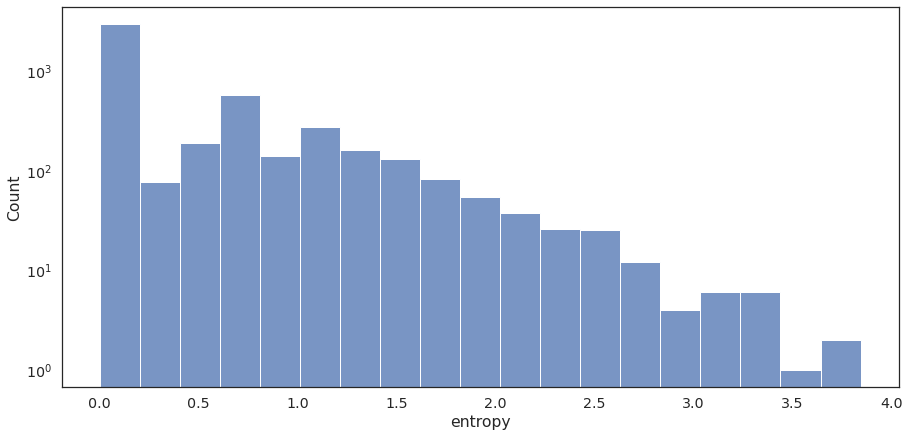

In [17]:
sns.histplot(data=words_em_voc.entropy, log_scale=(False, True), bins='doane');

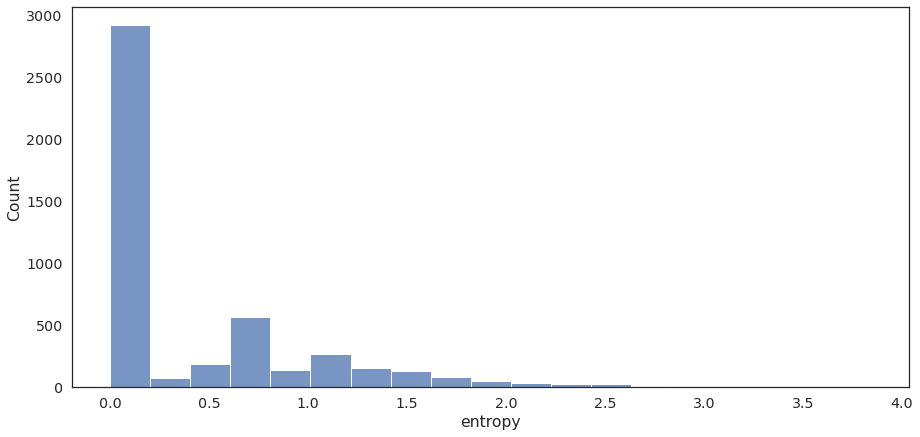

In [18]:
sns.histplot(data=words_em_voc.entropy, bins='doane');

### Variation in emoji space per word

In [25]:
e2v = gs.KeyedVectors.load_word2vec_format(E2V_EMBEDDINGS, binary=True)

In [26]:
calculate_vocabulary_variation(words_em_voc["emoji"].iloc[0], e2v)

0.0

In [27]:
happy = words_em_voc[words_em_voc.word == 'happy'].emoji.values[0]
calculate_vocabulary_variation(happy, e2v)

0.3088506073814577

In [28]:
words_em_voc['variation'] = words_em_voc.emoji.apply(lambda x: calculate_vocabulary_variation(x, e2v))

In [29]:
words_em_voc.nlargest(n=10, columns='variation')[['word', 'emoji', 'variation']]

,word,emoji,variation
4294,traveling,"{'⛴️': 1, '✈️': 1, '🚁': 1, '🚆': 1, '🚉': 1, '🚊': 1, '🚗': 1, '🚝': 1, '🛣️': 1}",0.621276
648,cell,"{'🈚': 1, '🏨': 1, '📞': 1, '📲': 1, '🤳': 1, '🦠': 1}",0.616001
409,board,"{'🈯': 1, '👡': 1, '👩‍🏫': 1, '🔘': 1, '🚧': 1, '🛷': 1}",0.604323
778,class,"{'🍹': 1, '👨‍🏫': 1, '📝': 1}",0.595540
884,contact,"{'©️': 1, '👤': 1, '👥': 1, '📇': 1}",0.593228
512,build,"{'🎢': 1, '🏢': 1, '🏪': 1, '📊': 1, '🛠️': 1, '🛢️': 1}",0.588517
999,cup,"{'⌛': 1, '🍶': 2, '🏆': 3, '🔋': 1, '🔖': 1, '🥣': 1, '🥤': 3}",0.577000
3674,sitting,"{'🏮': 1, '👩‍🦽': 1, '🦼': 1, '🪑': 1}",0.570225
4257,toy,"{'🎊': 1, '🎠': 1, '👨‍🚒': 1, '🤷': 1, '🦧': 1, '🧝': 1, '🧸': 1}",0.568961
1152,dislike,"{'⚫': 1, '👅': 1, '👎': 1, '🙅': 1}",0.565678


In [30]:
words_em_voc.nsmallest(n=10, columns='variation')

,word,emoji,entropy,variation
0,TRUE,{'✌️': 1},0.0,0.0
2,aardvark,{'🦡': 1},0.0,0.0
3,ab,{'🆎': 10},0.0,0.0
4,abacus,{'🧮': 13},0.0,0.0
5,abbreviations,{'🔣': 1},0.0,0.0
6,abc,{'🔤': 3},0.0,0.0
7,abcd,{'🔠': 2},0.0,0.0
9,abe,{'🔤': 1},0.0,0.0
11,abstract,{'♒': 1},0.0,0.0
12,accepting,{'🤲': 1},0.0,0.0


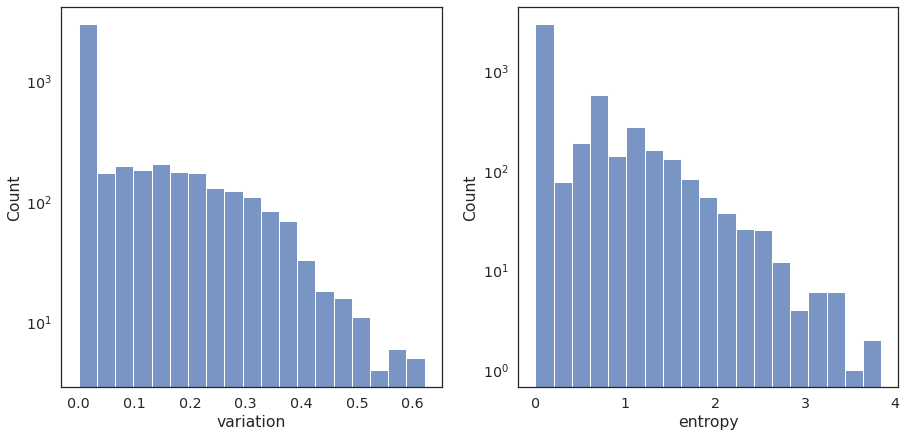

In [31]:
fig, axes = plt.subplots(1, 2)
sns.histplot(words_em_voc.variation, log_scale=(False, True), bins='doane', ax=axes[0]);
sns.histplot(words_em_voc.entropy, log_scale=(False, True), bins='doane', ax=axes[1]);

In [32]:
words_em_voc.describe()

,entropy,variation
count,4698.000000,4698.000000
mean,0.401191,0.073183
std,0.616899,0.117377
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.693147,0.129006
max,3.845106,0.621276


In [33]:
words_em_voc

,word,emoji,entropy,variation
0,TRUE,{'✌️': 1},0.000000,0.000000
1,a,"{'⛎': 1, '🅰️': 16, '🈁': 1, '🈂️': 1, '🎎': 1, '💢': 1, '💯': 1}",1.074614,0.184354
2,aardvark,{'🦡': 1},0.000000,0.000000
3,ab,{'🆎': 10},0.000000,0.000000
4,abacus,{'🧮': 13},0.000000,0.000000
...,...,...,...,...
4693,zipper,"{'🚠': 1, '🤐': 1}",0.693147,0.315452
4694,zodiac,"{'♈': 1, '♉': 1, '♊': 3, '♌': 3, '♍': 1, '♎': 5, '♏': 2, '♐': 1, '♑': 2, '♒': 1, '♓': 3, '⛎': 1, '➰': 1, '➿': 1, '🈸': 1, '💹': 1, '🔯': 1}",2.653251,0.235861
4695,zodiccircle,{'⚛️': 1},0.000000,0.000000
4696,zombie,"{'🧞': 1, '🧟': 22}",0.178845,0.025469


In [34]:
top_ten = words_em_voc.sort_values(by='variation', ascending=False)[:20]

In [35]:
top_ten.head()

,word,emoji,entropy,variation
4294,traveling,"{'⛴️': 1, '✈️': 1, '🚁': 1, '🚆': 1, '🚉': 1, '🚊': 1, '🚗': 1, '🚝': 1, '🛣️': 1}",2.197225,0.621276
648,cell,"{'🈚': 1, '🏨': 1, '📞': 1, '📲': 1, '🤳': 1, '🦠': 1}",1.791759,0.616001
409,board,"{'🈯': 1, '👡': 1, '👩‍🏫': 1, '🔘': 1, '🚧': 1, '🛷': 1}",1.791759,0.604323
778,class,"{'🍹': 1, '👨‍🏫': 1, '📝': 1}",1.098612,0.595540
884,contact,"{'©️': 1, '👤': 1, '👥': 1, '📇': 1}",1.386294,0.593228


<AxesSubplot:xlabel='entropy', ylabel='variation'>

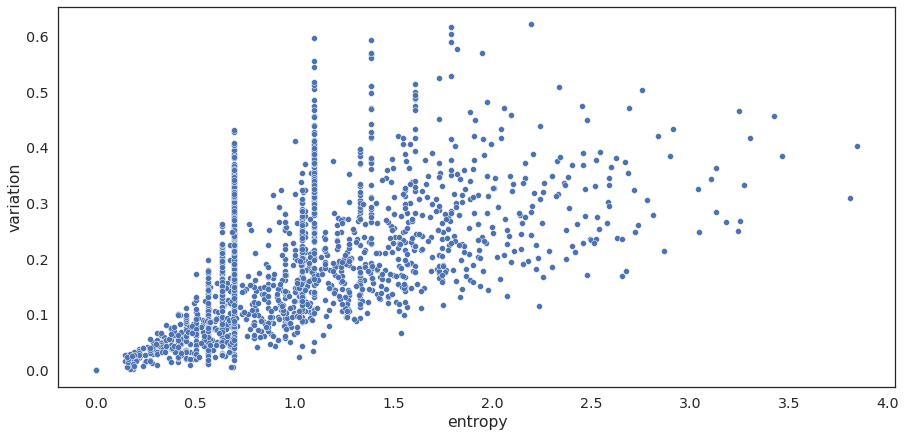

In [36]:
sns.scatterplot(data=words_em_voc, x='entropy', y='variation')

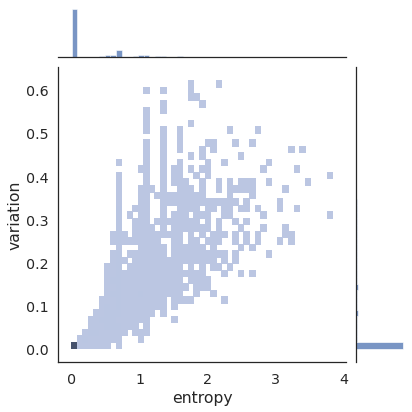

In [37]:
sns.jointplot(data=words_em_voc, x='entropy', y='variation', kind='hist')

In [38]:
print("Bootstrapping...")
func = lambda partial_df: partial_df.apply(lambda row: embedded_CIs(calculate_vocabulary_variation,
                                                                    row.emoji, e2v),
                                           axis=1)
CIs = parallelize_dataframe(top_ten, func)
top_ten["CIs"] = CIs

Bootstrapping...


  0%|          | 0/4 [00:00<?, ?it/s]

<BarContainer object of 20 artists>

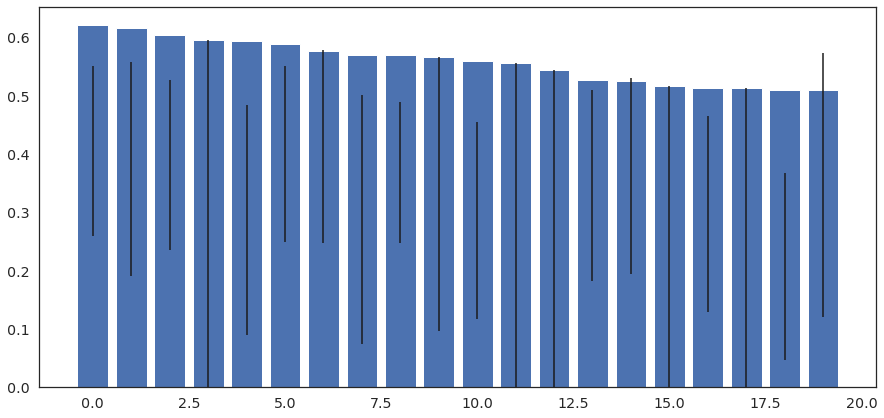

In [39]:
fig, ax = plt.subplots()

df = top_ten
col = 'variation'
CIs = np.array(df.CIs.to_list()).T
low = df[col].values - CIs[0, :]
high = CIs[1, :] - df['variation'].values
ax.bar(range(len(df.index)), df[col].to_list(), yerr=np.vstack((low, high)))